In [1]:
import numpy as np
from scipy.optimize import minimize


def minkowski_distance(a, b, p):
    difference = np.subtract(a, b)
    absolute_difference = np.abs(difference)
    power_in_sum = np.power(absolute_difference, p)
    summa = np.sum(power_in_sum)
    return np.power(summa, 1/p)


# def minkowski_distance(x, y, p):
#     if len(x) != len(y):
#         raise ValueError("Vectors x and y must have the same length")
#     return = np.power(np.sum(np.power(np.abs(x - y), p)), 1/p)

# def minkowski_distance(x, y, p):
#     """Calculate the Minkowski distance between two points."""
#     return np.sum(np.abs(x - y) ** p) ** (1 / p)


class KMeans:
    def __init__(self, n_clusters, max_iter=100, p=2, optimizer='mean'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.p = p
        self.optimizer = optimizer
        self.centroids = []
        self.labels = []

    def fit(self, X):
        # initialize centroids randomly
        self.centroids = [X[i] for i in np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            clusters = [[] for _ in range(self.n_clusters)]
            self.labels = []

            # assign each data point to the closest centroid
            for x in X:
                distances_to_each_cebtroid = [minkowski_distance(x, centroid, self.p) for centroid in self.centroids]
                closest_centroid = np.argmin(distances_to_each_cebtroid)
                clusters[closest_centroid].append(x)
                self.labels.append(closest_centroid)

            # update centroids using the specified optimizer
            for j, cluster in enumerate(clusters):
                cluster = np.array(cluster)
                if len(cluster) == 0:
                    continue
                if self.optimizer == 'mean':
                    self.centroids[j] = cluster.mean(axis=0)
                elif self.optimizer == 'median':
                    self.centroids[j] = np.median(cluster, axis=0)
                elif self.optimizer == 'SLSQP':
                    bounds = [(None, None)] * self.centroids[j].shape[0]
                    self.centroids[j] = minimize(
                        lambda x: minkowski_distance(x, cluster, self.p),
                        self.centroids[j].flatten(),
                        method=self.optimizer,
                        bounds=bounds
                    ).x.copy()
                elif self.optimizer in ('Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'trust-constr'):
                    self.centroids[j] = minimize(lambda x: minkowski_distance(x, cluster, self.p), self.centroids[j], method=self.optimizer).x.copy()
                else:
                    raise ValueError(f"Unsupported optimizer: {self.optimizer}")

        return self.centroids, self.labels

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_clusters(k, means, stds, n_points_per_cluster, X, distance_factor=1):
    clusters = []
    labels = []
    for i in range(k):
        mean, std = means[i] * distance_factor, stds[i]
        cov = np.identity(X) * std ** 2
        points = np.random.multivariate_normal(mean, cov, n_points_per_cluster)
        clusters.append(points)
        labels.append(np.full((n_points_per_cluster,), i))
    return np.concatenate(clusters), np.concatenate(labels)

In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def make_plots(axs, index, color_map, data, labels, opt_name=''):
    colors = [color_map[label] for label in labels]

    tsne = TSNE(n_components=2)
    data_2d = tsne.fit_transform(data)

    axs[index, 0].scatter(data_2d[:,0], data_2d[:,1], c=colors)
    axs[index, 0].axis('off')
    # axs[index, 0].set_xlabel('t-SNE Dimension 1')
    # axs[index, 0].set_ylabel('t-SNE Dimension 2')
    axs[index, 0].set_title(f'{opt_name} in 2D via t-SNE')

    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)

    axs[index, 1].scatter(data_2d[:,0], data_2d[:,1], c=colors)
    axs[index, 1].axis('off')
    # axs[index, 1].set_xlabel('PCA Dimension 1')
    # axs[index, 1].set_ylabel('PCA Dimension 2')
    axs[index, 1].set_title(f'{opt_name} in 2D via PCA')


In [4]:
n_clusters = 3
assert n_clusters <= 5, "n_clusters must be less than or equal to 5"
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'yellow', 4: 'purple'}


optimizers = [
    'mean',
    'median', 
    # 'Powell',
    # 'CG',
    # 'BFGS',
    # 'L-BFGS-B',
    # 'TNC', 
    'COBYLA',
    'SLSQP', 
    #  'trust-constr'
]

dimensions = [2, 20]
distance_factors = [0.5, 1]

p_map = {'mean': 2, 'median': 1}

params = {'dimension': dimensions,  'distance_factor': distance_factors, 'optimizer': optimizers}


from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import mutual_info_score
import pandas as pd

def print_metrics(true_labels, data_map):
    ari = []
    ami = []
    for optimizer in optimizers:
        pred_lable = data_map[optimizer]
        ari.append(adjusted_rand_score(true_labels, pred_lable))
        ami.append(mutual_info_score(true_labels, pred_lable))

    print(pd.DataFrame({'Adjusted Rand Index': ari, 'Mutual Information Score': ami}, index=optimizers))

Processed mean with p 2
Processed median with p 1
Processed COBYLA with p 0.5
Processed SLSQP with p 0.5


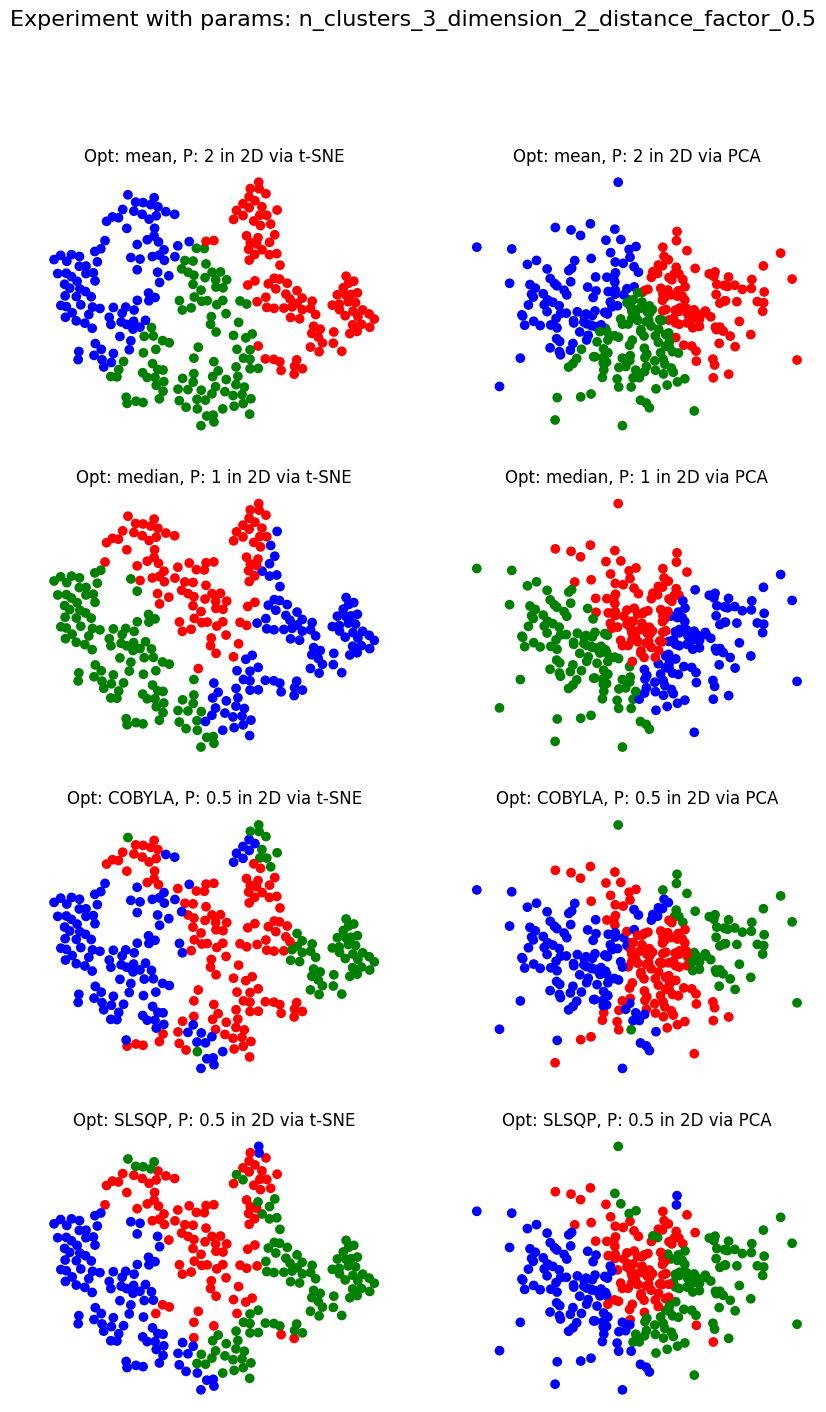

        Adjusted Rand Index  Mutual Information Score
mean               0.292530                  0.321760
median             0.230025                  0.284018
COBYLA             0.169192                  0.209912
SLSQP              0.210744                  0.240617
Processed mean with p 2
Processed median with p 1
Processed COBYLA with p 0.5
Processed SLSQP with p 0.5


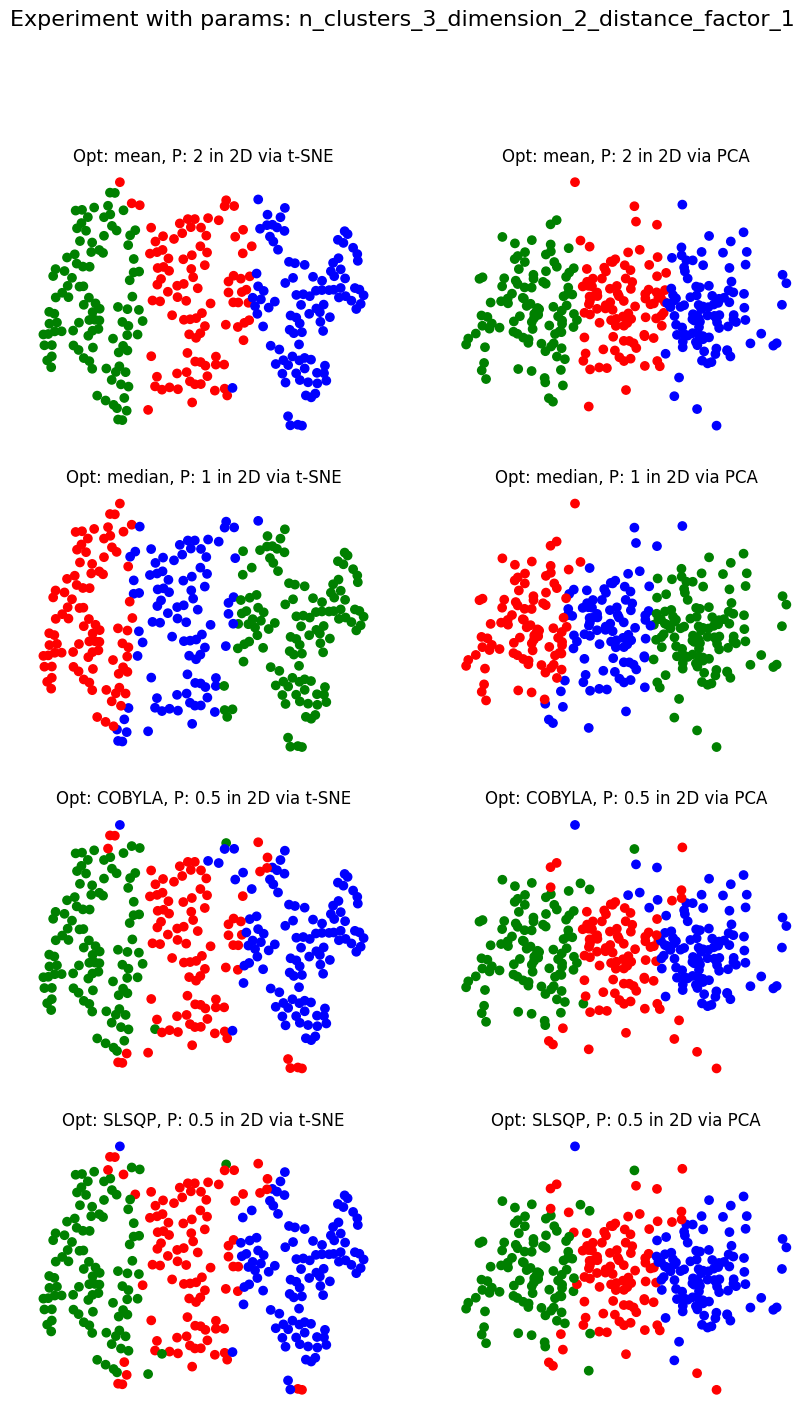

        Adjusted Rand Index  Mutual Information Score
mean               0.712490                  0.732810
median             0.632590                  0.673276
COBYLA             0.555605                  0.585971
SLSQP              0.578379                  0.606130
Processed mean with p 2
Processed median with p 1
Processed COBYLA with p 0.5
Processed SLSQP with p 0.5


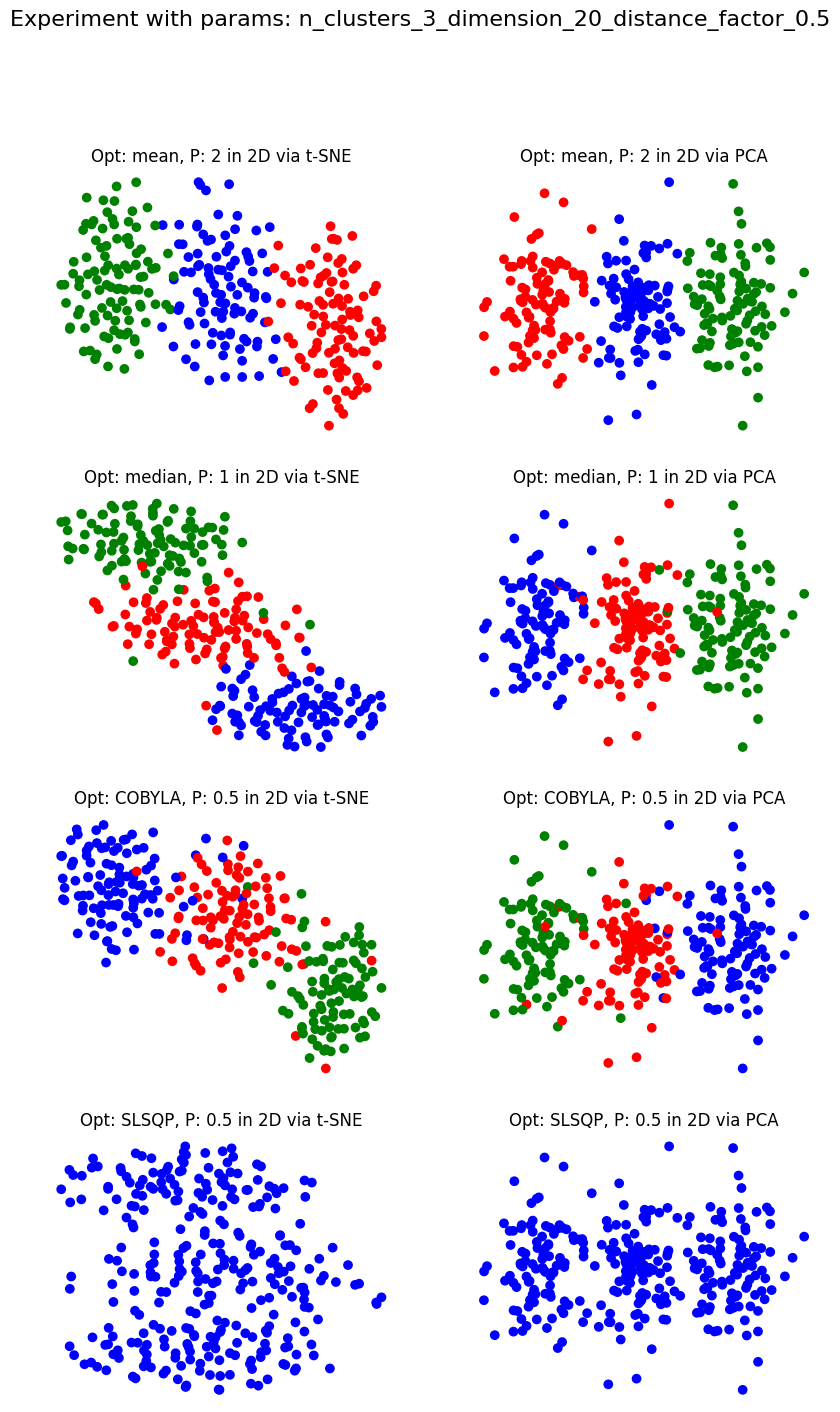

        Adjusted Rand Index  Mutual Information Score
mean               0.989983                  1.079912
median             0.902630                  0.957153
COBYLA             0.813114                  0.852413
SLSQP              0.000000                  0.000000
Processed mean with p 2
Processed median with p 1
Processed COBYLA with p 0.5
Processed SLSQP with p 0.5


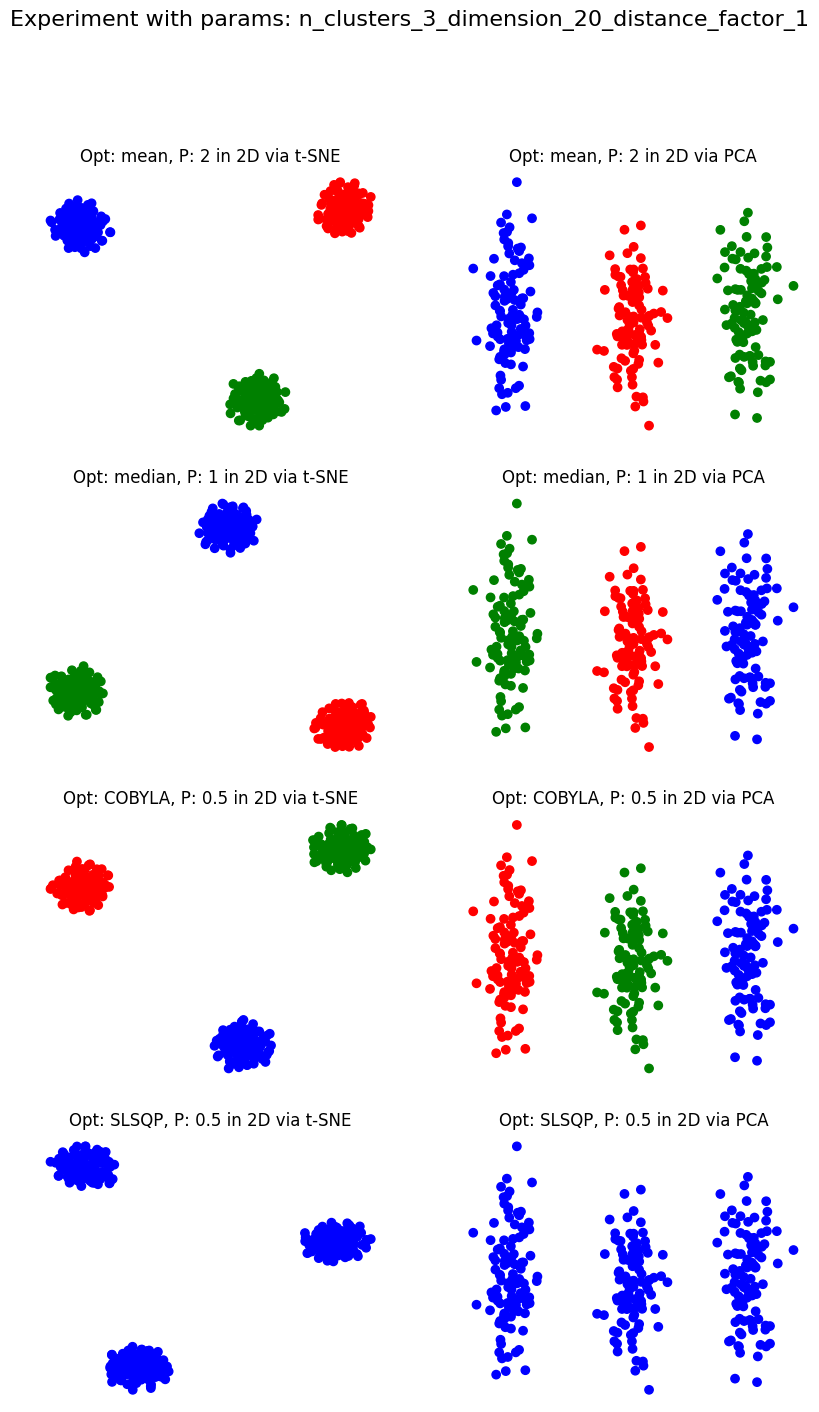

        Adjusted Rand Index  Mutual Information Score
mean                    1.0                  1.098612
median                  1.0                  1.098612
COBYLA                  1.0                  1.098612
SLSQP                   0.0                  0.000000


In [5]:
for dimension in params['dimension']:
    means = [np.zeros(dimension), np.ones(dimension), -np.ones(dimension), np.ones(dimension) * -1 + 1, np.ones(dimension) + -1]
    stds = [0.5, 0.5, 0.5, 0.5, 0.5]
    n_points_per_cluster = 100

    for distance_factor in params['distance_factor']:
        data, true_labels = generate_clusters(n_clusters, means, stds, n_points_per_cluster, dimension, distance_factor)

        optimizers = params['optimizer']
        data_map = dict.fromkeys(optimizers)

        len_optimizers = len(optimizers)
        fig, axs = plt.subplots(len_optimizers, 2, figsize=(10, 4*len_optimizers))

        experiment_name = f'n_clusters_{n_clusters}_dimension_{dimension}_distance_factor_{distance_factor}'
        fig.suptitle(f'Experiment with params: {experiment_name}', fontsize=16)

        for index, optimizer in enumerate(optimizers):

            p = p_map.get(optimizer, 0.5)

            kmeans = KMeans(n_clusters=n_clusters, optimizer=optimizer, p=p)
            centroids, labels = kmeans.fit(data)
            data_map[optimizer] = labels

            make_plots(axs, index, color_map, data, labels, f'Opt: {optimizer}, P: {p}')
            print(f'Processed {optimizer} with p {p}')
        plt.show()
        fig.savefig(f'images/{experiment_name}.png', dpi=600)

        print_metrics(true_labels, data_map)


# Test

In [35]:
import numpy as np
from scipy.optimize import minimize

def kmeans_obj(X, r, centroids):
    # Calculate the k-means objective function
    obj = 0
    for k in range(len(centroids)):
        obj += np.sum((X[r==k] - centroids[k])**2)
    return obj

def optimize_centroids(X, k):
    # Randomly initialize the cluster centroids
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]
    
    # Define the function to be optimized
    def f(centroids_flat):
        centroids = centroids_flat.reshape(k, -1)
        r = np.argmin(np.sum((X[:, np.newaxis, :] - centroids)**2, axis=2), axis=1)
        obj = kmeans_obj(X, r, centroids)
        return obj
    
    # Flatten the centroids array for the optimizer
    x0 = centroids.flatten()
    
    # Define the bounds for the optimizer
    bounds = [(None, None)] * x0.shape[0]
    
    # Call the minimize function with the SLSQP optimizer
    result = minimize(f, x0, method='SLSQP', bounds=bounds)
    
    # Reshape the optimized centroids array
    centroids = result.x.reshape(k, -1)
    
    return centroids



# Generate some sample data with 3 features
dimension = 50
means = [np.zeros(dimension), np.ones(dimension), -np.ones(dimension), np.ones(dimension) * -1 + 1, np.ones(dimension) + -1]
stds = [0.5, 0.5, 0.5, 0.5, 0.5]
data, true_labels = generate_clusters(2, means, stds, 100, dimension, 1)

# Optimize the cluster centroids
centroids = optimize_centroids(data, k=3)

# Print the optimized centroids
print("Optimized centroids:\n", centroids)



Optimized centroids:
 [[ 0.02184599  0.01582636  0.08565559  0.04904732  0.05656201 -0.00431265
   0.02651121 -0.00816545  0.03847081 -0.03032619 -0.03722719 -0.07056265
   0.11582087  0.05089307 -0.01913637  0.01930585  0.07154172 -0.04709084
  -0.02320932 -0.10510062  0.01027066  0.02538071  0.04823859 -0.01768174
   0.03701743 -0.05547828 -0.03140228 -0.01105485  0.02302035 -0.03566936
  -0.0199458   0.03113983  0.03208562  0.07716761  0.05298986 -0.02186242
  -0.0088583   0.01931615  0.04858517 -0.00389963  0.02343439  0.06373581
  -0.0348564   0.02529171  0.05050382 -0.04988297 -0.04960596 -0.00496082
  -0.00913833  0.02131124]
 [ 1.00889995  0.97814247  1.02521798  0.91929843  0.97260587  0.9275196
   0.98114255  1.02869014  1.04414557  1.06762779  0.96758499  1.05609508
   0.98630355  0.95188227  0.98284177  0.95159943  0.97311083  1.00486553
   1.01194024  0.95722039  1.066799    0.95484179  1.0270497   0.9333934
   1.02408926  1.03922038  0.94004759  1.09242305  0.9501112   0.